# Gaussian Model

In [25]:
%matplotlib inline
import numpy
import pyparticleest.utils.kalman as kalman
import pyparticleest.interfaces as interfaces
import matplotlib.pyplot as plt
import pyparticleest.simulator as simulator


In [26]:
def generate_dataset(steps, P0, Q, R):
    x = numpy.zeros((steps + 1,))
    y = numpy.zeros((steps,))
    x[0] = 2.0 + 0.0 * numpy.random.normal(0.0, P0)
    for k in range(1, steps + 1):
        x[k] = x[k - 1] + numpy.random.normal(0.0, Q)
        y[k - 1] = x[k] + numpy.random.normal(0.0, R)

    return (x, y)

In [27]:
class Model(interfaces.ParticleFiltering):
    """ x_{k+1} = x_k + v_k, v_k ~ N(0,Q)
        y_k = x_k + e_k, e_k ~ N(0,R),
        x(0) ~ N(0,P0) """

    def __init__(self, P0, Q, R):
        self.P0 = numpy.copy(P0)
        self.Q = numpy.copy(Q)
        self.R = numpy.copy(R)

    def create_initial_estimate(self, N):
        return numpy.random.normal(0.0, self.P0, (N,)).reshape((-1, 1))

    def sample_process_noise(self, particles, u, t):
        """ Return process noise for input u """
        N = len(particles)
        return numpy.random.normal(0.0, self.Q, (N,)).reshape((-1, 1))

    def update(self, particles, u, t, noise):
        """ Update estimate using 'data' as input """
        particles += noise

    def measure(self, particles, y, t):
        """ Return the log-pdf value of the measurement """
        logyprob = numpy.empty(len(particles), dtype=float)
        for k in range(len(particles)):
            logyprob[k] = kalman.lognormpdf(particles[k].reshape(-1, 1) - y, self.R)
        return logyprob

    def logp_xnext_full(self, part, past_trajs, pind,
                        future_trajs, find, ut, yt, tt, cur_ind):

        diff = future_trajs[0].pa.part[find] - part

        logpxnext = numpy.empty(len(diff), dtype=float)
        for k in range(len(logpxnext)):
            logpxnext[k] = kalman.lognormpdf(diff[k].reshape(-1, 1), numpy.asarray(self.Q).reshape(1, 1))
        return logpxnext

In [28]:
steps = 50
N=200
M=50
P0 = 1.0
Q = 1.0
R = numpy.asarray(((1.0,),))

In [29]:
%%time
numpy.random.seed(1)
(x, y) = generate_dataset(steps, P0, Q, R)


CPU times: user 438 µs, sys: 195 µs, total: 633 µs
Wall time: 638 µs


In [30]:
%%time
model = Model(P0, Q, R)
sim = simulator.Simulator(model, u=None, y=y)

CPU times: user 199 µs, sys: 3 µs, total: 202 µs
Wall time: 206 µs


In [31]:
%%time
sim.simulate(N, M, smoother='full') #we could see the difference between full & ancestor

CPU times: user 17.5 s, sys: 125 ms, total: 17.6 s
Wall time: 18.2 s


33

In [32]:
(vals, _) = sim.get_filtered_estimates()
svals = sim.get_smoothed_estimates()

In [33]:
svals.shape

(51, 50, 1)

In [34]:
vals.shape

(51, 200, 1)

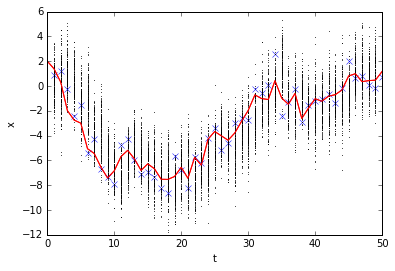

In [35]:
plt.plot(range(steps + 1), x, 'r-')
plt.plot(range(1, steps + 1), y, 'bx')
plt.plot(range(steps + 1), vals[:, :, 0], 'k.', markersize=0.8)
#plt.plot(range(steps + 1), svals[:, :, 0], 'b--')
plt.plot(range(steps + 1), x, 'r-')
plt.xlabel('t')
plt.ylabel('x')

In [36]:
x.shape

(51,)